In [ ]:
""" IN THE NAME OF  ALLAH , THE MOST GRACIOUS, THE MOST MERCIFUL. """

In [1]:
import sys
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor
from torch.utils.data import DataLoader, random_split

modules_path = 'C:/Users/PMLS/FYP/Modules/'
dataset_path = 'C:/Users/PMLS/FYP/Dataset/STMM'
save_path = "C:/Users/PMLS/FYP/Models"

sys.path.insert(1, modules_path)
from video_dataset import VideoFrameDataset, ImglistToTensor

if False and torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

C:\Users\PMLS\anaconda3\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\PMLS\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


cpu


In [2]:
# Define transforms
import cv2
import pywt
def wavelet_transform(batch):
        batch2=[]
        for frame in batch:
            A, B = pywt.dwt(frame, 'db1')
            batch2.append(B)
        return np.array(batch2)

def grey_transform(batch):
    batch = batch.transpose(0,1,3,4,2)
    favg = np.average(batch[0], axis=0)
    grey_avg = cv2.cvtColor(favg, cv2.COLOR_BGR2GRAY)
    batch2 = []
    for frame in batch[0]:
        frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame2 = frame2 - grey_avg
        threshhold = np.max(frame2) * 0.05
        _, frame2 = cv2.threshold(frame2, threshhold, 255, cv2.THRESH_BINARY)
        batch2.append(frame2)
    return np.array([batch2])
    
def local_transform(batch):
    batch = np.array(batch)
    new_batch = []
    #new_batch=grey_transform(batch)
    for b in batch:
        b = wavelet_transform(b)
        new_batch.append(b)
    return torch.tensor(np.array(new_batch))

In [5]:
# Define model
class NN5(torch.nn.Module):
    """
    5 Layer neural network
    ReLU activation function between all layers
    Layer sizes given by 6 element list `layer_sizes`
    """
    def __init__(self, layer_sizes):
        super(NN5, self).__init__()
        self.layer1 = torch.nn.Linear(layer_sizes[0],layer_sizes[1])
        self.relu1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(layer_sizes[1],layer_sizes[2])
        self.relu2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(layer_sizes[2],layer_sizes[3])
        self.relu3 = torch.nn.ReLU()
        self.layer4 = torch.nn.Linear(layer_sizes[3],layer_sizes[4])
        self.relu4 = torch.nn.ReLU()
        self.layer5 = torch.nn.Linear(layer_sizes[4],layer_sizes[5])

    def forward(self, x):
        out1 = self.layer1(x)
        out1_2 = self.relu1(out1)
        out2 = self.layer2(out1_2)
        out2_2 = self.relu2(out2)
        out3 = self.layer3(out2_2)
        out3_2 = self.relu3(out3)
        out4 = self.layer4(out3_2)
        out4_2 = self.relu4(out4)
        out5 = self.layer5(out4_2)
        return out5

torch.set_default_dtype(torch.float32)
device = torch.device("cpu")
model = NN5([3686400,10,10,5,5,4]).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

In [7]:
model = torch.load(save_path+"/model4.model").to(device)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_14824\821659381.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(save_path+"/model4.model").to(device)


In [83]:
vp=0
def videoplot(x):
    x = np.array(x, dtype=np.int32)
    global vp
    vp=vp+1
    plt.figure(vp,figsize=(15,5))
    for i in range(7):
        plt.subplot(1,7,i+1)
        plt.imshow(x[i].transpose(1,2,0))
        
def Predict(x):
    x = np.array(x).transpose(0,1,4,2,3)
    print("Cam avg:", np.average(x), np.var(x))
    #videoplot(x[0])
    x = local_transform(x)
    x = x.flatten(start_dim=1).to(device)
    
    y_hat = model(x)
    _, y_hat = torch.max(y_hat,1)
    print("Predicted label = ", class_map[int(y_hat[0])])

def captureVideo():
    # Captures videos
    batch = []
    video = []
    i=0
    while i/frames_per_video < 10:
        i+=1
        # Capture a frome
        ret, frame = cam.read()
        
        # Display the captured frame
        cv2.imshow('Camera', frame)
        frame = np.array(frame, dtype=np.float32)
        frame = cv2.resize(frame, (img_w, img_h))
        time.sleep(1/frame_rate)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)/255
        video.append(frame)
        if len(video)==frames_per_video:
            Predict([video])
            video=[]
            
        # Press 'q' to exit the loop
        if cv2.waitKey(1) == ord('q'):
            break
            
    cam.release()
    cv2.destroyAllWindows()

In [85]:
# Run
img_w = 640
img_h = 480
frames_per_video = 8
batch_size = 10
frame_rate = 10
class_map = {0:"down", 1:"left", 2:"right", 3:"up"}

# Open the default camera
cam = cv2.VideoCapture(0)

try:
    captureVideo()
except Exception as e:
    print("Error:", e)
    cam.release()
    cv2.destroyAllWindows()

Cam avg: 0.4422469 0.06499528
Predicted label =  left
Cam avg: 0.40590996 0.060954638
Predicted label =  left
Cam avg: 0.38748637 0.05129053
Predicted label =  right
Cam avg: 0.39591682 0.048008736
Predicted label =  right
Cam avg: 0.4432129 0.05734618
Predicted label =  left
Cam avg: 0.43555263 0.062097557
Predicted label =  left
Cam avg: 0.46097937 0.06356083
Predicted label =  left
Cam avg: 0.4504259 0.06426115
Predicted label =  right
Cam avg: 0.449252 0.06456616
Predicted label =  left
Cam avg: 0.4515903 0.06427355
Predicted label =  left


In [53]:
cam.release()
cv2.destroyAllWindows()

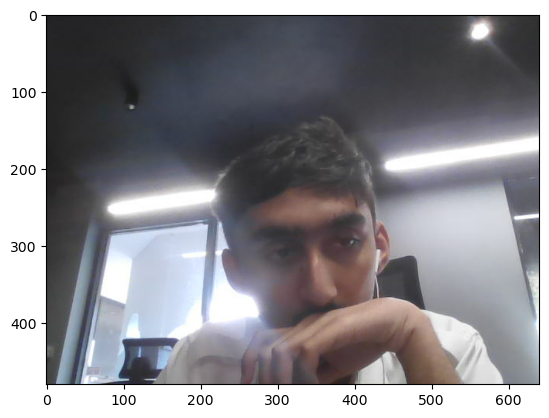

In [19]:
cam = cv2.VideoCapture(0)
ret, frame = cam.read()
cam.release()

#frame=np.array(frame)
frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)